In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
MT_FIGURE_DIR = '/home/quent/Documents/repos/latex/master-thesis/figures/'

## PCA

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 1000)).T

pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=4,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');
plt.axis('off');
plt.savefig('pca_2d.eps')
# sns.despine(left=True, bottom=True, right=True, top=True)

## Activations

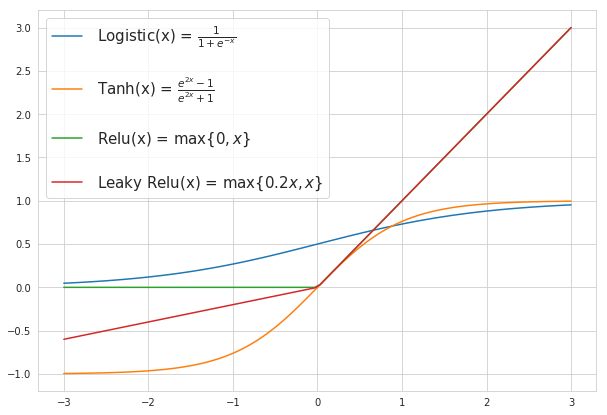

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,7), sharey=True)

def relu(x):
    """$\\max\\{0, x\\}$"""
    return np.where(x > 0, x, np.zeros_like(x))

def logistic(x):
    """$\\frac{1}{1+e^{-x}}$"""
    return 1/(1+np.exp(-x))

def tanh(x):
    """$\\frac{e^{2x}-1}{e^{2x}+1}$"""
    return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)

def leaky_relu(x, leak=0.2):
    """$\\max\\{0.2x, x\\}$"""
    return np.where(x > 0, x, x * leak)

for func in [logistic, tanh, relu, leaky_relu]:
    xx = np.linspace(-3,3,100)
    ax.plot(xx, func(xx), label="(x) = ".join([func.__name__.replace('_', ' ').title(), func.__doc__]))
    
plt.legend(fontsize=15, handletextpad=1.0, labelspacing=1.7);

plt.savefig(MT_FIGURE_DIR + 'activation_functions.eps')

## SVM: Maximum margin separating hyperplane
Plot the maximum margin separating hyperplane within a two-class separable dataset using a Support Vector Machine classifier with linear kernel.

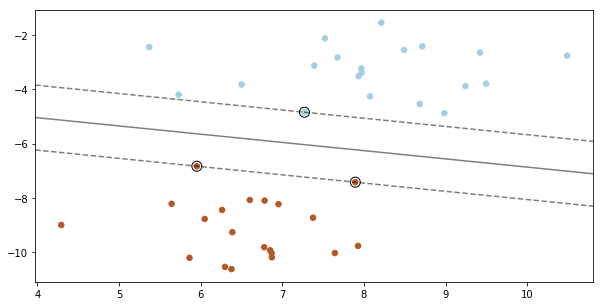

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.gcf().set_size_inches((10,5))
plt.tight_layout()
# plt.savefig(MT_FIGURE_DIR + 'svm_hyperplane.eps')

## Overfitting, Underfitting, Capacity
This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called underfitting. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will overfit the training data, i.e. it learns the noise of the training data. We evaluate quantitatively overfitting / underfitting by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

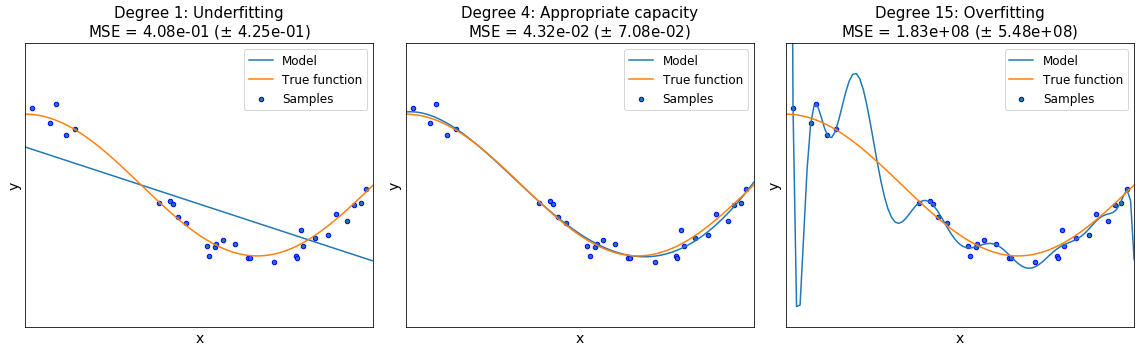

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best", fontsize=12)
    titles = ['Underfitting', 'Appropriate capacity', 'Overfitting']
    plt.title("Degree {}: {}\nMSE = {:.2e} ($\pm$ {:.2e})".format(
        degrees[i], titles[i], -scores.mean(), scores.std()), fontdict={'fontsize': 15})

plt.gcf().set_size_inches((16, 5))
plt.tight_layout()
plt.savefig(MT_FIGURE_DIR + 'overfitting.eps')